Some Reseach Questions: 
•	How do traditional statistical models (e.g., Logistic Regression, Cox Proportional Hazards) compare to machine learning models (e.g., Random Forests, Neural Networks) in predicting bankruptcy?
•	Can ensemble methods improve the accuracy of bankruptcy prediction compared to standalone models?
•	Which financial ratios related to profitability, liquidity, leverage, efficiency, coverage and Altman z-score, etc. are the most significant predictors of bankruptcy across industries?
•	How does the size of a company (e.g., small vs. large enterprises) influence the effectiveness of bankruptcy prediction models?
•	How do economic crises or recessions impact bankruptcy risk?

Some additional issues with the data: 
As a baseline we do what were doing: i.e. assume that by dropping duplicates everything is ok.
There are multiple events for any given company. Does that mean that they were in chapter 11? In which case, if we make that assumption then we can set that as another variable.**Need to count these cases.**
There seem to be cases where the company is no longer in the dataset before the end of the period, but no failure is recorded. Should they be recorded as chapter 7? Or should we treat them as missing data? Or should they be dropped? **Need to count these cases.**
How many cases of companies are there of companies that entered the dataset during this period? Or are all left_censored? Do we need to have a variable for left_censored?
Do a count of the number of unique companies by year. Do a unique count of the number of failures by year.
Introduce some lags. This can be done without setting up a new feature.



In [122]:
import pandas as pd

# Define the file path
file_path = r'C:\Users\deanh\OneDrive\DSI\modules\Company-Bankruptcy-Prediction\american_bankruptcy.csv'

# Load the data
df = pd.read_csv(file_path)

# Display the first few rows
print(df.head())


  company_name status_label  year       X1       X2      X3      X4       X5  \
0          C_1        alive  1999  511.267  833.107  18.373  89.031  336.018   
1          C_1        alive  2000  485.856  713.811  18.577  64.367  320.590   
2          C_1        alive  2001  436.656  526.477  22.496  27.207  286.588   
3          C_1        alive  2002  396.412  496.747  27.172  30.745  259.954   
4          C_1        alive  2003  432.204  523.302  26.680  47.491  247.245   

       X6       X7  ...        X9      X10      X11     X12      X13      X14  \
0  35.163  128.348  ...  1024.333  740.998  180.447  70.658  191.226  163.816   
1  18.531  115.187  ...   874.255  701.854  179.987  45.790  160.444  125.392   
2 -58.939   77.528  ...   638.721  710.199  217.699   4.711  112.244  150.464   
3 -12.410   66.322  ...   606.337  686.621  164.658   3.573  109.590  203.575   
4   3.504  104.661  ...   651.958  709.292  248.666  20.811  128.656  131.261   

       X15       X16      X17   

In [123]:
df['status_label'].value_counts()


status_label
alive     73462
failed     5220
Name: count, dtype: int64

In [124]:
# Count the number of unique companies in the dataset
num_unique_companies = df['company_name'].nunique()

print("Number of unique companies in the dataset:", num_unique_companies)

Number of unique companies in the dataset: 8971


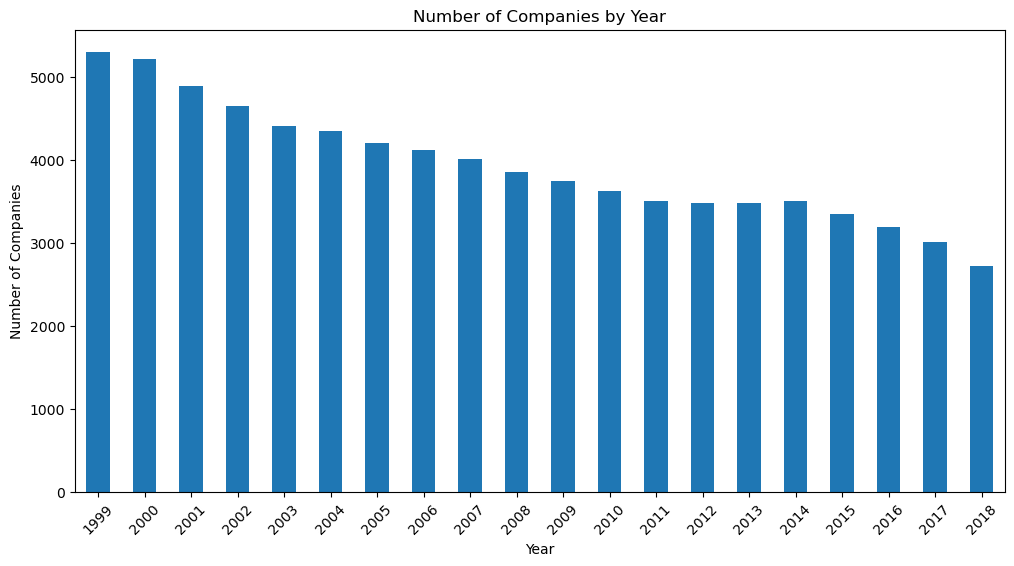

In [125]:
# Plot the number of companies in each year
import matplotlib.pyplot as plt

# Count the number of unique companies for each year
companies_by_year = df.groupby('year')['company_name'].nunique()

# Plot the results using a bar plot
plt.figure(figsize=(12, 6))
companies_by_year.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Number of Companies')
plt.title('Number of Companies by Year')
plt.xticks(rotation=45)
plt.show()

Number of left-censored companies (first year is 1999): 5308


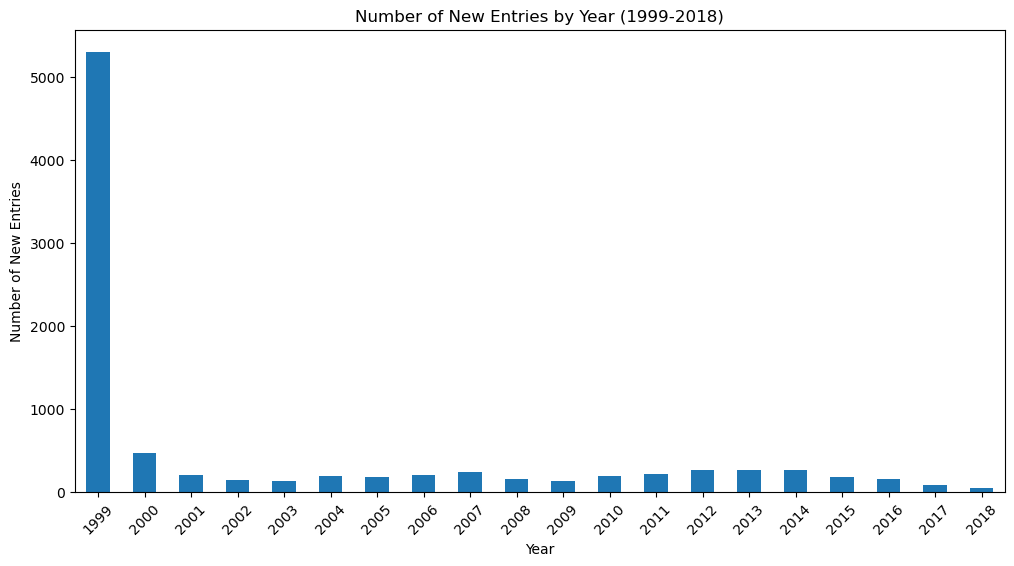

In [126]:
# Identify the first year each company appears in the dataset

# Plot the count of the first year each company appears in the dataset
first_year = df.groupby('company_name')['year'].min().reset_index()
first_year.columns = ['company_name', 'first_year']

# Filter the DataFrame to include only companies whose first year is 1999
left_censored_companies = first_year[first_year['first_year'] == 1999]

# Count the number of left-censored companies
num_left_censored_companies = left_censored_companies['company_name'].nunique()

print("Number of left-censored companies (first year is 1999):", num_left_censored_companies)

# Filter the DataFrame to include only rows where the first year is 1999 or later
first_year_after_1999 = first_year[first_year['first_year'] >= 1999]

# Count the number of new entries for each year
new_entries_by_year = first_year_after_1999['first_year'].value_counts().sort_index()

# Plot the results using a bar plot
plt.figure(figsize=(12, 6))
new_entries_by_year.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Number of New Entries')
plt.title('Number of New Entries by Year (1999-2018)')
plt.xticks(rotation=45)
plt.show()

EXPLORING THE TARGET

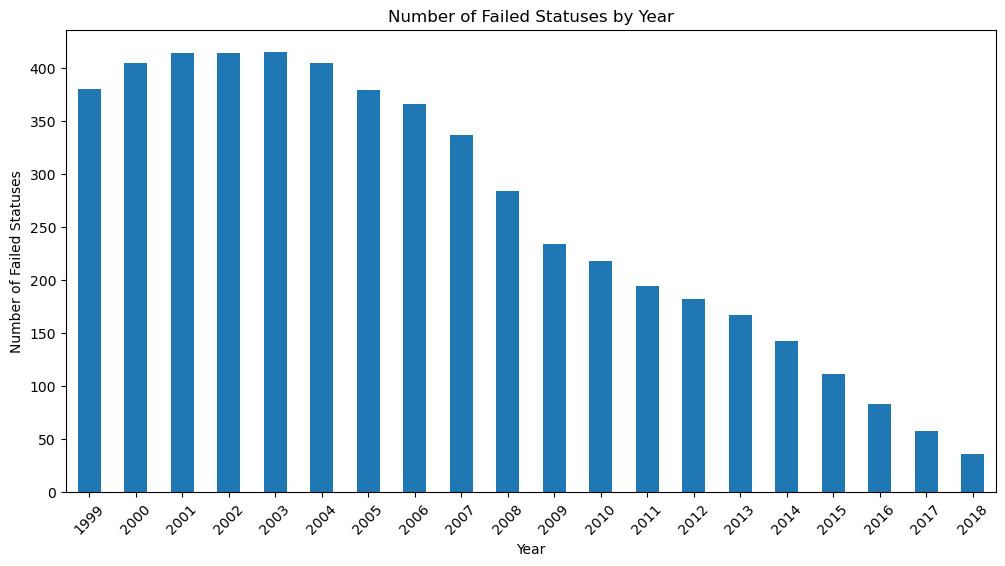

In [127]:
# Plot the 'failed' statuses by year

# Filter the DataFrame to include only rows where status_label is 'failed'
failed_df = df[df['status_label'] == 'failed']

# Count the number of 'failed' statuses for each year
failed_by_year = failed_df['year'].value_counts().sort_index()

# Plot the results using a bar plot
plt.figure(figsize=(12, 6))
failed_by_year.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Number of Failed Statuses')
plt.title('Number of Failed Statuses by Year')
plt.xticks(rotation=45)
plt.show()

In [128]:
# Check for multiple failed statuses for each company
# Filter the DataFrame to include only rows where status_label is 'failed'
failed_df = df[df['status_label'] == 'failed']

# Group by company_name and count the number of occurrences of 'failed' status for each company
failed_counts = failed_df.groupby('company_name').size()

# Filter to include only companies with more than one 'failed' status
companies_with_multiple_failures = failed_counts[failed_counts > 1]

# Count the number of such companies
num_companies_with_multiple_failures = companies_with_multiple_failures.count()

print("Number of companies with more than one 'failed' status:", num_companies_with_multiple_failures)

Number of companies with more than one 'failed' status: 599


In [129]:
# Find the maximum count of 'failed' statuses for any company
# Filter the DataFrame to include only rows where status_label is 
# 'failed'
failed_df = df[df['status_label'] == 'failed']

# Group by company_name and count the number of 'failed' statuses for each company
failed_counts = failed_df.groupby('company_name').size()

# Find the maximum count of 'failed' statuses for any company
max_failed_count = failed_counts.max()

print("Maximum count of 'failed' statuses for any company:", max_failed_count)

Maximum count of 'failed' statuses for any company: 20


In [130]:
# How many observations would be lost if we removed all observations 
# for each company that occur after the first 'failed' status for that 
# company? 

# Sort the DataFrame by company_name and year
df = df.sort_values(by=['company_name', 'year'])

# Identify the first occurrence of 'failed' status for each company
first_failed = df[df['status_label'] == 'failed'].groupby('company_name')['year'].min().reset_index()
first_failed.columns = ['company_name', 'first_failed_year']

# Merge the first_failed DataFrame with the original DataFrame
df = df.merge(first_failed, on='company_name', how='left')

# Filter out observations that occur after the first 'failed' status for each company
observations_to_drop = df[(df['status_label'] == 'failed') & (df['year'] > df['first_failed_year'])]

# Count the number of observations that would be lost
num_observations_lost = observations_to_drop.shape[0]

print("Number of observations that would be lost:", num_observations_lost)

Number of observations that would be lost: 4611


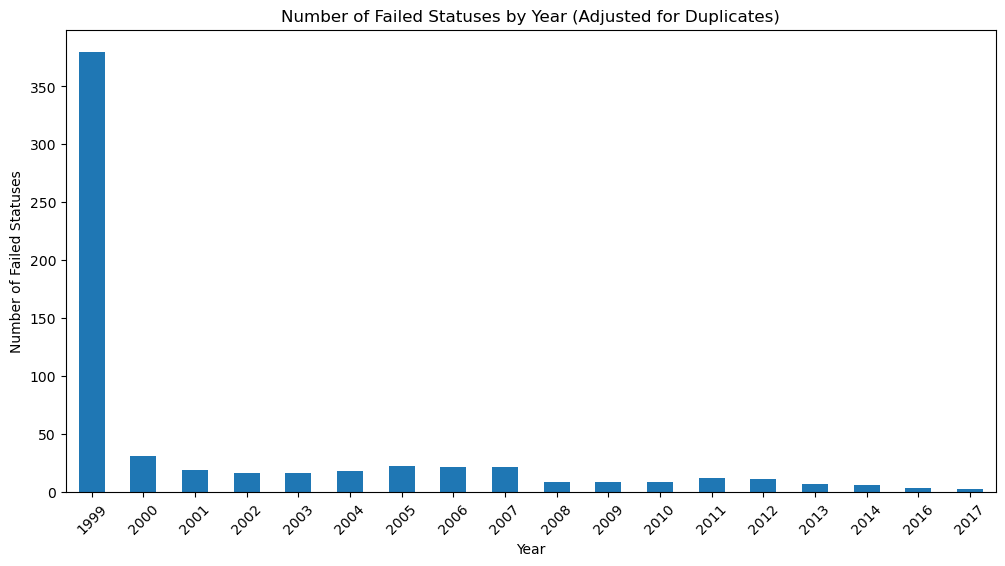

In [131]:
# Plot the failed companies by year using the first instance of 
# 'failed' year for each company

# Filter the DataFrame to include only rows where status_label is 'failed'
failed_df = df[df['status_label'] == 'failed']

# Remove duplicates by keeping only the first instance of 'failed' status for each company
failed_df = failed_df.drop_duplicates(subset='company_name', keep='first')

# Count the number of 'failed' statuses for each year
failed_by_year = failed_df['year'].value_counts().sort_index()

# Plot the results using a bar plot
plt.figure(figsize=(12, 6))
failed_by_year.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Number of Failed Statuses')
plt.title('Number of Failed Statuses by Year (Adjusted for Duplicates)')
plt.xticks(rotation=45)
plt.show()

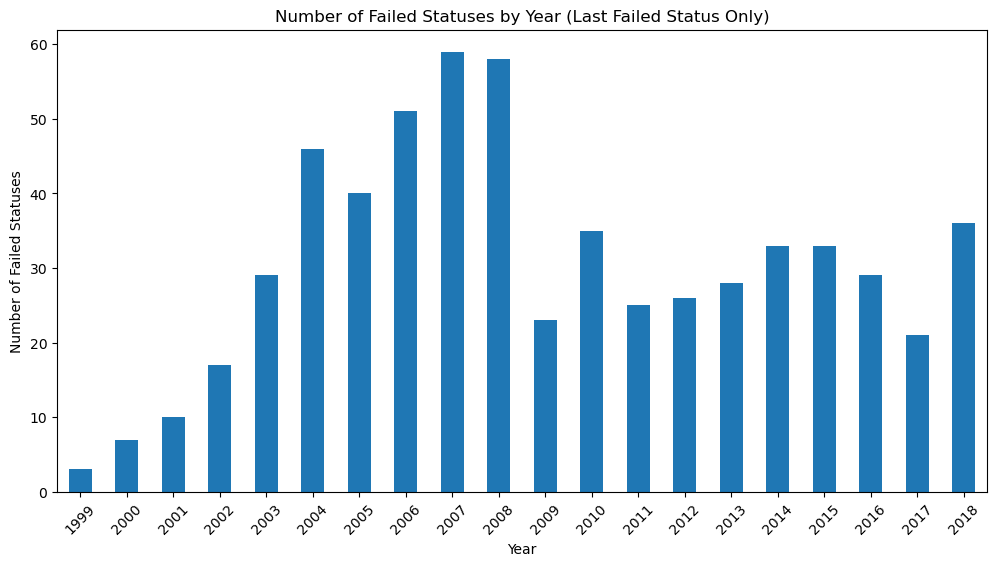

In [132]:
# Plot the failed companies by year using the last instance of
# 'failed' year for each company

# Filter the DataFrame to include only rows where status_label is 'failed'
failed_df_original = df[df['status_label'] == 'failed']

# Remove duplicates by keeping only the last instance of 'failed' status for each company
failed_df_last = failed_df_original.drop_duplicates(subset='company_name', keep='last')

# Count the number of 'failed' statuses for each year
failed_by_year_last = failed_df_last['year'].value_counts().sort_index()

# Plot the results using a bar plot
plt.figure(figsize=(12, 6))
failed_by_year_last.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Number of Failed Statuses')
plt.title('Number of Failed Statuses by Year (Last Failed Status Only)')
plt.xticks(rotation=45)
plt.show()

In [133]:
# Check on the total number of 'failed' statuses (original and 
# adjusted): should 5220 - 609 (= 4611) 
# Filter the DataFrame to include only rows where status_label is 'failed'
failed_df_original = df[df['status_label'] == 'failed']

# Count the total number of 'failed' statuses (original)
total_failed_original = failed_df_original.shape[0]

# Remove duplicates by keeping only the first instance of 'failed' status for each company
failed_df_first = failed_df_original.drop_duplicates(subset='company_name', keep='first')

# Count the total number of 'failed' statuses (first instance)
total_failed_first = failed_df_first.shape[0]

# Remove duplicates by keeping only the last instance of 'failed' status for each company
failed_df_last = failed_df_original.drop_duplicates(subset='company_name', keep='last')

# Count the total number of 'failed' statuses (last instance)
total_failed_last = failed_df_last.shape[0]

# Print the total counts
print("Total count of 'failed' statuses (original):", total_failed_original)
print("Total count of 'failed' statuses (first instance):", total_failed_first)
print("Total count of 'failed' statuses (last instance):", total_failed_last)

Total count of 'failed' statuses (original): 5220
Total count of 'failed' statuses (first instance): 609
Total count of 'failed' statuses (last instance): 609


In [134]:
# Check if there are any companies with 'alive' status after any
# 'failed' status
# Identify companies with at least one 'failed' status
companies_with_failed = df[df['status_label'] == 'failed']['company_name'].unique()

# Filter the DataFrame to include only these companies and sort by company_name and year
filtered_df = df[df['company_name'].isin(companies_with_failed)].sort_values(by=['company_name', 'year'])

# Count companies with 'alive' status after any 'failed' status
num_companies_with_alive_after_failed = sum(
    any((row['status_label'] == 'alive') and (row['year'] > failed_year)
        for _, row in company_df.iterrows())
    for company, company_df in filtered_df.groupby('company_name')
)

# Print the count
print("Number of companies with 'alive' status after any 'failed' status:", num_companies_with_alive_after_failed)

Number of companies with 'alive' status after any 'failed' status: 0


There are a number of companies that have more than one 'failed' status. And at least one of these has a 'failed' status across all years. Since it is highly unlikely that a company remains in chapter 11 for so long, these are likely mislabeled. A couple of possible approaches: 

1. drop all companies with multiple 'failed': 599 companies (which means that 599 companies account for 5220 - 609 failures, which wouldn't leave many remaining failures)
2. drop all of 1999: because we don't know which of these is a duplicate from the prior period. But that's 350+ 'failed' observations which would greatly reduce the number of 'failed'. 
3. drop all observations after the first 'failed' in companies with more than one. (this seems implausible)
4. relabel all but the last 'failed' with 'alive' (or set up new label). (This is the most plausible approach.)

The original dataset had a total of 5220 'failed' status across all companies and years. De-duplicating by year reduces the 'failed' to 609, which means 6.8% of 8971 companies failed. Using the first instance of 'failed' (and dropping the rest) reduces the dataset of 73462 by 4611 variables to 68851. Using the last retains the original data structure.


SET UP A NEW TARGET VARIABLE 

In [135]:
# Set up new target variable for last instance of 'failed' status
# Summarize the target_last column
# Identify the last instance of 'failed' status for each company
df['target_last'] = 0  # Initialize the new variable with 0
last_failed_indices = df[df['status_label'] == 'failed'].groupby('company_name')['year'].idxmax()

# Set the last instance of 'failed' status to 1
df.loc[last_failed_indices, 'target_last'] = 1

# Summarize the target_last column
print("Summary of target_last:\n", df['target_last'].value_counts())

Summary of target_last:
 target_last
0    78073
1      609
Name: count, dtype: int64


SET UP DATA FOR ANALYSIS

Variable descriptions: 
**X1	Current assets** - All the assets of a company that are expected to be sold or used as a result of standard business operations over the next year
**X2	Cost of goods sold** - The total amount a company paid as a cost directly related to the sale of products
**X3	Depreciation and amortization** - Depreciation refers to the loss of value of a tangible fixed asset over time (such as property, machinery, buildings, and plant). Amortization refers to the loss of value of intangible assets over time.
**X4	EBITDA** - Earnings before interest, taxes, depreciation, and amortization. It is a measure of a company's overall financial performance, serving as an alternative to net income.
**X5	Inventory** - The accounting of items and raw materials that a company either uses in production or sells.
**X6	Net Income** - The overall profitability of a company after all expenses and costs have been deducted from total revenue.
**X7	Total Receivables** - The balance of money due to a firm for goods or services delivered or used but not yet paid for by customers.
**X8	Market value** - The price of an asset in a marketplace. In this dataset, it refers to the market capitalization since companies are publicly traded in the stock market.
**X9	Net sales** - The sum of a company's gross sales minus its returns, allowances, and discounts.
**X10	Total assets** - All the assets, or items of value, a business owns.
**X11	Total Long-term debt** - A company's loans and other liabilities that will not become due within one year of the balance sheet date.
**X12	EBIT** - Earnings before interest and taxes.
**X13	Gross Profit** - The profit a business makes after subtracting all the costs that are related to manufacturing and selling its products or services.
**X14	Total Current Liabilities** - The sum of accounts payable, accrued liabilities, and taxes such as Bonds payable at the end of the year, salaries, and commissions remaining.
**X15	Retained Earnings** - The amount of profit a company has left over after paying all its direct costs, indirect costs, income taxes, and its dividends to shareholders.
**X16	Total Revenue** - The amount of income that a business has made from all sales before subtracting expenses. It may include interest and dividends from investments.
**X17	Total Liabilities** - The combined debts and obligations that the company owes to outside parties.
**X18	Total Operating Expenses** - The expenses a business incurs through its normal business operations.

The most relevant variable to include would be one of the following as a proxy for company size (transformed):
X8 - market value
X10 - total assets* usually the most stable over time
Profit measures could also be used, but are much more variable.

In [136]:
# Check column names
print(df.columns)

# Summary of the dataset (e.g., variable types, non-null counts)
print(df.info())


Index(['company_name', 'status_label', 'year', 'X1', 'X2', 'X3', 'X4', 'X5',
       'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16',
       'X17', 'X18', 'first_failed_year', 'target_last'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78682 entries, 0 to 78681
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   company_name       78682 non-null  object 
 1   status_label       78682 non-null  object 
 2   year               78682 non-null  int64  
 3   X1                 78682 non-null  float64
 4   X2                 78682 non-null  float64
 5   X3                 78682 non-null  float64
 6   X4                 78682 non-null  float64
 7   X5                 78682 non-null  float64
 8   X6                 78682 non-null  float64
 9   X7                 78682 non-null  float64
 10  X8                 78682 non-null  float64
 11  X9                 78682 

In [ ]:
# Check for missing values
print(df.isnull().sum())

# Check for duplicated rows
print(df.duplicated().sum())

# Check the shape of the dataset
print(df.shape)

In [138]:
# Display summary statistics for the main variables
main_features = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 
                 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 
                 'X16', 'X17', 'X18']
summary_stats = df[main_features].describe().round(3)   

print(summary_stats)

               X1          X2         X3         X4         X5          X6  \
count   78682.000   78682.000  78682.000  78682.000  78682.000   78682.000   
mean      880.362    1594.529    121.234    376.759    201.606     129.382   
std      3928.565    8930.485    652.377   2012.023   1060.766    1265.532   
min        -7.760    -366.645      0.000 -21913.000      0.000  -98696.000   
25%        18.924      17.038      1.192     -0.811      0.000      -7.416   
50%       100.450     103.661      7.930     15.035      7.023       1.616   
75%       431.527     634.548     47.972    139.655     74.747      40.144   
max    169662.000  374623.000  28430.000  81730.000  62567.000  104821.000   

              X7           X8          X9         X10         X11        X12  \
count  78682.000    78682.000   78682.000   78682.000   78682.000  78682.000   
mean     286.833     3414.355    2364.020    2867.111     722.484    255.525   
std     1335.979    18414.104   11950.069   12917.944    

In [139]:
# Calculate skewness for the main variables
skewness = df[main_features].skew()

print(skewness)

X1     14.843279
X2     20.052194
X3     17.860473
X4     16.403531
X5     22.568626
X6     11.866809
X7     15.844958
X8     18.194283
X9     18.987110
X10    13.562208
X11    14.848021
X12    17.968030
X13    15.295829
X14    14.225186
X15    29.607949
X16    18.987110
X17    13.767802
X18    20.384520
dtype: float64


In [ ]:
# This runs alternative tests of skewness in a given variable. All 
# X1-X18 variables are skewed so need to be transformed. But only two 
# are especially relevant X8, and X10 which be a proxy for company 
# size. Choose the one with the result closest to zero and use that 
# transformation.
# 
import numpy as np
from scipy.stats import boxcox

def test_skewness(column):
    # Log Transformation
    df[f'{column}_log'] = np.log1p(df[column])

    # Square Root Transformation
    df[f'{column}_sqrt'] = np.sqrt(df[column])

    # Box-Cox Transformation (requires positive values)
    df[f'{column}_boxcox'], _ = boxcox(df[column] + 1)  # Adding 1 to ensure all values are positive

    # Reciprocal Transformation
    df[f'{column}_reciprocal'] = 1 / (df[column] + 1)  # Adding 1 to avoid division by zero

    # Calculate skewness after transformation
    skewness_log = df[f'{column}_log'].skew()
    skewness_sqrt = df[f'{column}_sqrt'].skew()
    skewness_boxcox = df[f'{column}_boxcox'].skew()
    skewness_reciprocal = df[f'{column}_reciprocal'].skew()

    print(f'Skewness for {column} after log transformation: {skewness_log}')
    print(f'Skewness for {column} after square root transformation: {skewness_sqrt}')
    print(f'Skewness for {column} after Box-Cox transformation: {skewness_boxcox}')
    print(f'Skewness for {column} after reciprocal transformation: {skewness_reciprocal}')

# Test skewness for X8
test_skewness('X8')

# Test skewness for X10
test_skewness('X10')

Skewness for X8 after log transformation: 0.10678961133809589
Skewness for X8 after square root transformation: 4.997809056011178
Skewness for X8 after Box-Cox transformation: 0.007642593193632652
Skewness for X8 after reciprocal transformation: 4.5706195913672785
Skewness for X10 after log transformation: 0.04027402633070034
Skewness for X10 after square root transformation: 4.196588574823338
Skewness for X10 after Box-Cox transformation: 0.0023112959359959215
Skewness for X10 after reciprocal transformation: 4.376102695502445


In [141]:
# Drop the square root and reciprocal transformations for both X8 and 
# X10
columns_to_drop = ['X8_sqrt', 'X8_reciprocal', 'X10_sqrt', 'X10_reciprocal']
df.drop(columns=columns_to_drop, inplace=True)

# Print the remaining columns to verify
print("Remaining columns in the DataFrame:")
print(df.columns)

Remaining columns in the DataFrame:
Index(['company_name', 'status_label', 'year', 'X1', 'X2', 'X3', 'X4', 'X5',
       'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16',
       'X17', 'X18', 'first_failed_year', 'target_last', 'X8_log', 'X8_boxcox',
       'X10_log', 'X10_boxcox'],
      dtype='object')


In [142]:

# Drop the first_failed_year column from the original DataFrame
df.drop(columns=['first_failed_year'], inplace=True)


In [143]:
# Create a left_censored variable:
# Identify the first year in the dataset
first_year_in_dataset = df['year'].min()

# Identify the first year each company appears in the dataset
first_year_per_company = df.groupby('company_name')['year'].min()

# Create a new variable 'left_censored' where 1 indicates the company is left-censored
df['left_censored'] = df['company_name'].map(lambda x: 1 if first_year_per_company[x] == first_year_in_dataset else 0)

# Print the total count of left-censored companies
total_left_censored = df['left_censored'].sum()
print("Total count of left-censored companies:", total_left_censored)

Total count of left-censored companies: 54934


In [144]:
# Create a single dummy variable for the period
df['period_after_2008'] = df['year'].apply(lambda x: 1 if x > 2008 else 0)

# Verify the counts for the dummy variable
print("Count for years up to and including 2008 (0):", (df['period_after_2008'] == 0).sum())
print("Count for years after 2008 (1):", (df['period_after_2008'] == 1).sum())

Count for years up to and including 2008 (0): 45046
Count for years after 2008 (1): 33636


In [145]:
# Get a list of all variables (columns) in the DataFrame
all_variables = df.columns.tolist()

# Print the list of variables
print(all_variables)

['company_name', 'status_label', 'year', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'target_last', 'X8_log', 'X8_boxcox', 'X10_log', 'X10_boxcox', 'left_censored', 'period_after_2008']


NEW FEATURES

In [ ]:
# Create Financial Ratios and Derived Features
# The commented out ratios produce NaN values due to division by zero 
# or invalid values (could add 1 to denominator to avoid division by zero)

# Liquidity Ratios
df['current_ratio'] = df['X1'] / df['X14']
df['quick_ratio'] = (df['X1'] - df['X5']) / df['X14']

# Leverage Ratios
df['debt_to_equity_ratio'] = df['X17'] / (df['X10'] - df['X17'])
df['long_term_debt_to_assets'] = df['X11'] / df['X10']

# Profitability Ratios
df['profit_margin'] = df['X6'] / df['X16']
df['gross_margin'] = df['X13'] / df['X16']
df['return_on_assets'] = df['X6'] / df['X10']
df['return_on_equity'] = df['X6'] / (df['X10'] - df['X17'])

# Efficiency Ratios
df['asset_turnover'] = df['X9'] / df['X10']

# Altman Z-Score Components
df['working_capital_to_assets'] = (df['X1'] - df['X14']) / df['X10']
df['retained_earnings_to_assets'] = df['X15'] / df['X10']
df['ebit_to_assets'] = df['X12'] / df['X10']
df['market_value_to_liabilities'] = df['X8'] / df['X17']
df['sales_to_assets'] = df['X9'] / df['X10']

# Altman Z-Score
df['z_score'] = 1.2 * df['working_capital_to_assets'] + 1.4 * df['retained_earnings_to_assets'] + 3.3 * df['ebit_to_assets'] + 0.6 * df['market_value_to_liabilities'] + 1.0 * df['sales_to_assets']

# Bankruptcy Indicator
df['bankruptcy'] = (df['z_score'] < 1.81).astype(int)

# Market to book ratio
df['market_to_book'] = df['X8'] / (df['X10'] - df['X17'])   


# List of new features
'current_ratio'
'quick_ratio'
'debt_to_equity_ratio'
'long_term_debt_to_assets'
'profit_margin'
'gross_margin'
'return_on_assets'
'return_on_equity'
'asset_turnover'
'working_capital_to_assets'
'retained_earnings_to_assets'
'ebit_to_assets'
'market_value_to_liabilities'
'sales_to_assets'
'z_score'
'bankruptcy'
'market_to_book'
'left_censored'
'period_after_2008'  

In [ ]:
# Handle divisions by zero or invalid values
# df.replace([float('inf'), -float('inf')], pd.NA, inplace=True)
# df.dropna(inplace=True)

In [ ]:
# Leave out for now: these return too many NaN values
# Efficiency Ratios
# df['receivables_turnover'] = df['X9'] / df['X7']
# df['inventory_turnover'] = df['X2'] / df['X5']

# Coverage Ratios
# df['interest_coverage_ratio'] = df['X12'] / df['X11']  # Assuming interest expense = long-term debt
# df['debt_service_coverage_ratio'] = df['X4'] / df['X11']

# Growth Rates
# Sort the data by company name and year
# df = df.sort_values(by=['company_name', 'year'])

# Sales Growth
# df['sales_growth'] = df.groupby('company_name')['X9'].pct_change()

# EBITDA Growth
# df['ebitda_growth'] = df.groupby('company_name')['X4'].pct_change()


In [ ]:
# Creating change variables generates nan values for the first year 
# of each company. So either have to drop or fill with 0.
# Fill NaN values with 0
# df['sales_growth'] = df['sales_growth'].fillna(0)
# df['ebitda_growth'] = df['ebitda_growth'].fillna(0)

In [204]:
# Define the new features
new_features = [
    'current_ratio', 'quick_ratio', 'debt_to_equity_ratio', 'long_term_debt_to_assets',
    'profit_margin', 'gross_margin', 'return_on_assets', 'return_on_equity',
    'asset_turnover', 'working_capital_to_assets', 'retained_earnings_to_assets',
    'ebit_to_assets', 'market_value_to_liabilities', 'sales_to_assets', 'z_score',
    'bankruptcy', 'market_to_book', 'left_censored', 'period_after_2008'
]

# Check for missing values
missing_values = df[new_features].isnull().sum()
print("Missing values per column:\n", missing_values)

# Check for infinite values
inf_values = df[new_features].apply(lambda x: np.isinf(x).sum())
print("\nInfinite values per column:\n", inf_values)

# Check for duplicated rows
duplicated_rows = df[new_features].duplicated().sum()
print("\nNumber of duplicated rows:", duplicated_rows)

Missing values per column:
 current_ratio                  0
quick_ratio                    0
debt_to_equity_ratio           0
long_term_debt_to_assets       0
profit_margin                  0
gross_margin                   0
return_on_assets               0
return_on_equity               0
asset_turnover                 0
working_capital_to_assets      0
retained_earnings_to_assets    0
ebit_to_assets                 0
market_value_to_liabilities    0
sales_to_assets                0
z_score                        0
bankruptcy                     0
market_to_book                 0
left_censored                  0
period_after_2008              0
dtype: int64

Infinite values per column:
 current_ratio                  0
quick_ratio                    0
debt_to_equity_ratio           0
long_term_debt_to_assets       0
profit_margin                  0
gross_margin                   0
return_on_assets               0
return_on_equity               0
asset_turnover                 0
worki

Not all of these new features are relevant. Profitability, liquidity, leverage, efficiency and coverage can all impact financial viability, but typically you would choose one that fits best within category (there will be high collinearity between some especially for those that are alternative measures). The Altman Z-Score Components (Altman, 1968), and the Altman z-score are also typically used to assess the financial health of a company. From the new features, some are selected for further testing.

In [ ]:
# List of selected new features
selected_features = [
    'X8_boxcox', 'quick_ratio', 'debt_to_equity_ratio', 
    'long_term_debt_to_assets', 'profit_margin', 'return_on_assets', 
    'working_capital_to_assets', 'z_score', 'bankruptcy', 
    'market_to_book', 'period_after_2008', 'left_censored', 'year' 
]

# Convert the specified columns to numeric
for column in selected_features:
    df[column] = pd.to_numeric(df[column], errors='coerce')

# Display summary statistics for the newly created variables
summary_stats = df[selected_features].describe().round(3)

# Print the summary statistics
print("Summary Statistics:")
print(summary_stats)


Summary Statistics:
       X8_boxcox  quick_ratio  debt_to_equity_ratio  long_term_debt_to_assets  \
count  78682.000    78682.000             78682.000                 78682.000   
mean       0.000        0.000                 0.000                    -0.000   
std        1.000        1.000                 1.000                     1.000   
min       -2.320       -0.180               -17.309                    -0.025   
25%       -0.742       -0.024                -0.009                    -0.023   
50%        0.032       -0.018                -0.007                    -0.014   
75%        0.720       -0.005                -0.004                     0.002   
max        3.261      271.631               259.480                   277.850   

       profit_margin  return_on_assets  working_capital_to_assets     z_score  \
count      78682.000         78682.000                  78682.000   78682.000   
mean         -11.483             0.000                      0.000      -8.332   
std    

In [ ]:
# Check for NaN, inf, or -inf in the problematic columns
print("Number of NaN values:")
print(df[['return_on_equity', 'debt_to_equity_ratio', 'market_to_book']].isna().sum())

print("\nNumber of inf or -inf values:")
print((df[['return_on_equity', 'debt_to_equity_ratio', 'market_to_book']] == float('inf')).sum())
print((df[['return_on_equity', 'debt_to_equity_ratio', 'market_to_book']] == -float('inf')).sum())

In [ ]:
# Check for rows where X10 - X17 is close to 0
problematic_rows = df[(df['X10'] - df['X17']).abs() < 1e-6]
print("Number of problematic rows:", problematic_rows.shape[0])

# Get the indices of the problematic rows
problematic_indices = problematic_rows.index

# Find the rows before and after each problematic row
for idx in problematic_indices:
    print(f"\nProblematic row at index {idx}:")
    print(df.loc[idx, :])  # Print the problematic row

    # Print the row before, if it exists
    if idx - 1 in df.index:
        print("\nRow before:")
        print(df.loc[idx - 1, :])

    # Print the row after, if it exists
    if idx + 1 in df.index:
        print("\nRow after:")
        print(df.loc[idx + 1, :])

In [ ]:
# Replace inf and -inf with NaN to handle problematic values
df.replace([float('inf'), -float('inf')], pd.NA, inplace=True)

# Impute missing values in all derived variables with their respective medians
derived_variables = ['return_on_equity', 'debt_to_equity_ratio', 'market_to_book']
for var in derived_variables:
    df[var] = df[var].fillna(df[var].median())  # Explicitly assign the result back to the column

# Verify the fixes
print("Summary statistics after imputation:")
print(df[derived_variables].describe().round(3))

In [206]:
# Calculate skewness for the new features
skewness = df[selected_features].skew()

print(skewness)

X8_boxcox                      0.007643
quick_ratio                  257.002266
debt_to_equity_ratio         231.424985
long_term_debt_to_assets     272.933377
profit_margin                -67.698726
return_on_assets             -63.532971
working_capital_to_assets    -82.447206
z_score                       68.841659
bankruptcy                     0.556852
market_to_book               210.807006
period_after_2008              0.293132
left_censored                 -0.863443
year                           0.193910
dtype: float64


In [158]:
# This runs alternative tests of skewness in one variable. All X1-X18 
# variables are skewed so need to be transformed. You can choose the 
# one with the result closest to zero and use that transform.
# 
import numpy as np
from scipy.stats import boxcox

def test_skewness(column):
    # Log Transformation
    df[f'{column}_log'] = np.log1p(df[column])

    # Square Root Transformation
    df[f'{column}_sqrt'] = np.sqrt(df[column])

    # Box-Cox Transformation (requires positive values)
    # df[f'{column}_boxcox'], _ = boxcox(df[column] + 1)  # Adding 1 to ensure all values are positive

    # Reciprocal Transformation
    df[f'{column}_reciprocal'] = 1 / (df[column] + 1)  # Adding 1 to avoid division by zero

    # Calculate skewness after transformation
    skewness_log = df[f'{column}_log'].skew()
    skewness_sqrt = df[f'{column}_sqrt'].skew()
    # skewness_boxcox = df[f'{column}_boxcox'].skew()
    skewness_reciprocal = df[f'{column}_reciprocal'].skew()

    print(f'Skewness for {column} after log transformation: {skewness_log}')
    print(f'Skewness for {column} after square root transformation: {skewness_sqrt}')
    # print(f'Skewness for {column} after Box-Cox transformation: {skewness_boxcox}')
    print(f'Skewness for {column} after reciprocal transformation: {skewness_reciprocal}')

# Test skewness for selected variables
test_skewness('quick_ratio')
test_skewness('debt_to_equity_ratio')
test_skewness('long_term_debt_to_assets')
test_skewness('profit_margin')
test_skewness('return_on_assets')
test_skewness('working_capital_to_assets')
test_skewness('z_score')
test_skewness('market_to_book')

Skewness for quick_ratio after log transformation: 1.5177171566121905
Skewness for quick_ratio after square root transformation: 45.94464279754027
Skewness for quick_ratio after reciprocal transformation: 0.46977182214459495
Skewness for debt_to_equity_ratio after log transformation: nan
Skewness for debt_to_equity_ratio after square root transformation: nan
Skewness for debt_to_equity_ratio after reciprocal transformation: -80.30086316647224
Skewness for long_term_debt_to_assets after log transformation: 5.02452868988916
Skewness for long_term_debt_to_assets after square root transformation: 41.28688708831887
Skewness for long_term_debt_to_assets after reciprocal transformation: -1.2780219777512833
Skewness for profit_margin after log transformation: nan
Skewness for profit_margin after square root transformation: 31.782532195199643
Skewness for profit_margin after reciprocal transformation: nan
Skewness for return_on_assets after log transformation: nan
Skewness for return_on_assets 

c:\Users\deanh\miniconda3\envs\dsi_participant\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


Since most of the transformations require positive values, some
Nan values are returned. The boxcox returns an error vaiables with negative values. So need to shift before applying transformations.
Some of these transformations can be used: 
quick_ratio: reciprocal
long_term_debt_to_assets: reciprocal
working_capital_to_assets: square root
z_score: log

Variables requiring further processing:
debt_to_equity_ratio
profit_margin
return_on_assets
market_to_book

In [209]:
print("All columns in the DataFrame:")
print(df.columns)

All columns in the DataFrame:
Index(['company_name', 'status_label', 'year', 'X1', 'X2', 'X3', 'X4', 'X5',
       'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16',
       'X17', 'X18', 'target_last', 'X8_log', 'X8_boxcox', 'X10_log',
       'X10_boxcox', 'left_censored', 'period_after_2008', 'current_ratio',
       'quick_ratio', 'debt_to_equity_ratio', 'long_term_debt_to_assets',
       'profit_margin', 'gross_margin', 'return_on_assets', 'return_on_equity',
       'asset_turnover', 'working_capital_to_assets',
       'retained_earnings_to_assets', 'ebit_to_assets',
       'market_value_to_liabilities', 'sales_to_assets', 'z_score',
       'bankruptcy', 'market_to_book', 'quick_ratio_log', 'quick_ratio_sqrt',
       'quick_ratio_reciprocal', 'long_term_debt_to_assets_log',
       'long_term_debt_to_assets_sqrt', 'long_term_debt_to_assets_reciprocal',
       'working_capital_to_assets_log', 'working_capital_to_assets_sqrt',
       'working_capital_to_assets_recip

In [ ]:
# Variables requiring further processing: 
# debt_to_equity_ratio, 
# profit_margin, 
# return_on_assets, 
# market_to_book. 

# keep: 
# quick_ratio_reciprocal
# long_term_debt_to_assets_reciprocal, 
# working_capital_to_assets_sqrt
# z_score_log

In [208]:
# List of variables that require further processing
variables_to_process = [
    'debt_to_equity_ratio',
    'profit_margin',
    'return_on_assets',
    'market_to_book'
]

# Generate column names for square root, reciprocal, and log transformations
columns_to_drop = (
    [f"{var}_sqrt" for var in variables_to_process] +
    [f"{var}_reciprocal" for var in variables_to_process] +
    [f"{var}_log" for var in variables_to_process]  # Include log-transformed columns
)

# Drop the identified columns
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')  # Use errors='ignore' to avoid errors if columns don't exist

# Print the remaining columns to verify
print("Remaining columns in the DataFrame:")
print(df.columns)

Remaining columns in the DataFrame:
Index(['company_name', 'status_label', 'year', 'X1', 'X2', 'X3', 'X4', 'X5',
       'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16',
       'X17', 'X18', 'target_last', 'X8_log', 'X8_boxcox', 'X10_log',
       'X10_boxcox', 'left_censored', 'period_after_2008', 'current_ratio',
       'quick_ratio', 'debt_to_equity_ratio', 'long_term_debt_to_assets',
       'profit_margin', 'gross_margin', 'return_on_assets', 'return_on_equity',
       'asset_turnover', 'working_capital_to_assets',
       'retained_earnings_to_assets', 'ebit_to_assets',
       'market_value_to_liabilities', 'sales_to_assets', 'z_score',
       'bankruptcy', 'market_to_book', 'quick_ratio_log', 'quick_ratio_sqrt',
       'quick_ratio_reciprocal', 'long_term_debt_to_assets_log',
       'long_term_debt_to_assets_sqrt', 'long_term_debt_to_assets_reciprocal',
       'working_capital_to_assets_log', 'working_capital_to_assets_sqrt',
       'working_capital_to_assets

In [213]:
# Create shifted variables to ensure all values are strictly positive
variables_to_check = ['debt_to_equity_ratio', 'return_on_assets', 'working_capital_to_assets', 'market_to_book']

for column in variables_to_check:
    df[f'{column}_shifted'] = df[column] - df[column].min() + 1  # Shift to make all values > 0

# Verify the minimum values of the shifted variables
print(df[[f'{column}_shifted' for column in variables_to_check]].min())

debt_to_equity_ratio_shifted         1.0
return_on_assets_shifted             1.0
working_capital_to_assets_shifted    1.0
market_to_book_shifted               1.0
dtype: float64


In [214]:
# Test skewness for the shifted variables
shifted_variables = [f'{column}_shifted' for column in variables_to_check]

for column in shifted_variables:
    test_skewness(column)  # Reuse the test_skewness function from earlier

Skewness for debt_to_equity_ratio_shifted after log transformation: 44.130214453015896
Skewness for debt_to_equity_ratio_shifted after square root transformation: 167.89704523633083
Skewness for debt_to_equity_ratio_shifted after Box-Cox transformation: -13.348322630343828
Skewness for debt_to_equity_ratio_shifted after reciprocal transformation: 251.38729766650505
Skewness for return_on_assets_shifted after log transformation: -146.82927022976273
Skewness for return_on_assets_shifted after square root transformation: -95.87643455633737
Skewness for return_on_assets_shifted after Box-Cox transformation: 27.275272526224136
Skewness for return_on_assets_shifted after reciprocal transformation: 208.39072473634712


c:\Users\deanh\miniconda3\envs\dsi_participant\lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\deanh\miniconda3\envs\dsi_participant\lib\site-packages\numpy\core\_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


Skewness for working_capital_to_assets_shifted after log transformation: -219.4644224819821
Skewness for working_capital_to_assets_shifted after square root transformation: -131.46694038750294
Skewness for working_capital_to_assets_shifted after Box-Cox transformation: nan
Skewness for working_capital_to_assets_shifted after reciprocal transformation: 280.0250779426608
Skewness for market_to_book_shifted after log transformation: -39.206165745281055
Skewness for market_to_book_shifted after square root transformation: 130.2331341486615
Skewness for market_to_book_shifted after Box-Cox transformation: 11.108613676183197
Skewness for market_to_book_shifted after reciprocal transformation: 233.19889711218235


c:\Users\deanh\miniconda3\envs\dsi_participant\lib\site-packages\pandas\core\nanops.py:1260: RuntimeWarning: overflow encountered in multiply
  adjusted3 = adjusted2 * adjusted
c:\Users\deanh\miniconda3\envs\dsi_participant\lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
c:\Users\deanh\miniconda3\envs\dsi_participant\lib\site-packages\pandas\core\nanops.py:1272: RuntimeWarning: overflow encountered in scalar power
  result = (count * (count - 1) ** 0.5 / (count - 2)) * (m3 / m2**1.5)


In [216]:
# Check for constant values
print("Unique values in working_capital_to_assets_shifted:", df['working_capital_to_assets_shifted'].nunique())

# Check for extreme values
print("Summary statistics for working_capital_to_assets_shifted:")
print(df['working_capital_to_assets_shifted'].describe())

Unique values in working_capital_to_assets_shifted: 78641
Summary statistics for working_capital_to_assets_shifted:
count    78682.000000
mean       153.229359
std          1.000006
min          1.000000
25%        153.254106
50%        153.258280
75%        153.263384
max        153.277235
Name: working_capital_to_assets_shifted, dtype: float64


In [ ]:
# Apply the best transformations
df['debt_to_equity_ratio_shifted_boxcox'] = boxcox(df['debt_to_equity_ratio_shifted'])[0]
df['return_on_assets_shifted_boxcox'] = boxcox(df['return_on_assets_shifted'])[0]
df['market_to_book_shifted_boxcox'] = boxcox(df['market_to_book_shifted'])[0]


Transformed:
quick_ratio_reciprocal
long_term_debt_to_assets_reciprocal, 
working_capital_to_assets_sqrt
z_score_log
debt_to_equity_ratio_shifted_boxcox
return_on_assets_shifted_boxcox
market_to_book_shifted_boxcox

Investigate or preprocess working_capital_to_assets_shifted before transformation

In [ ]:
# Print the data types of the newly created variables
print("\nData Types:")
print(df[new_features].dtypes)

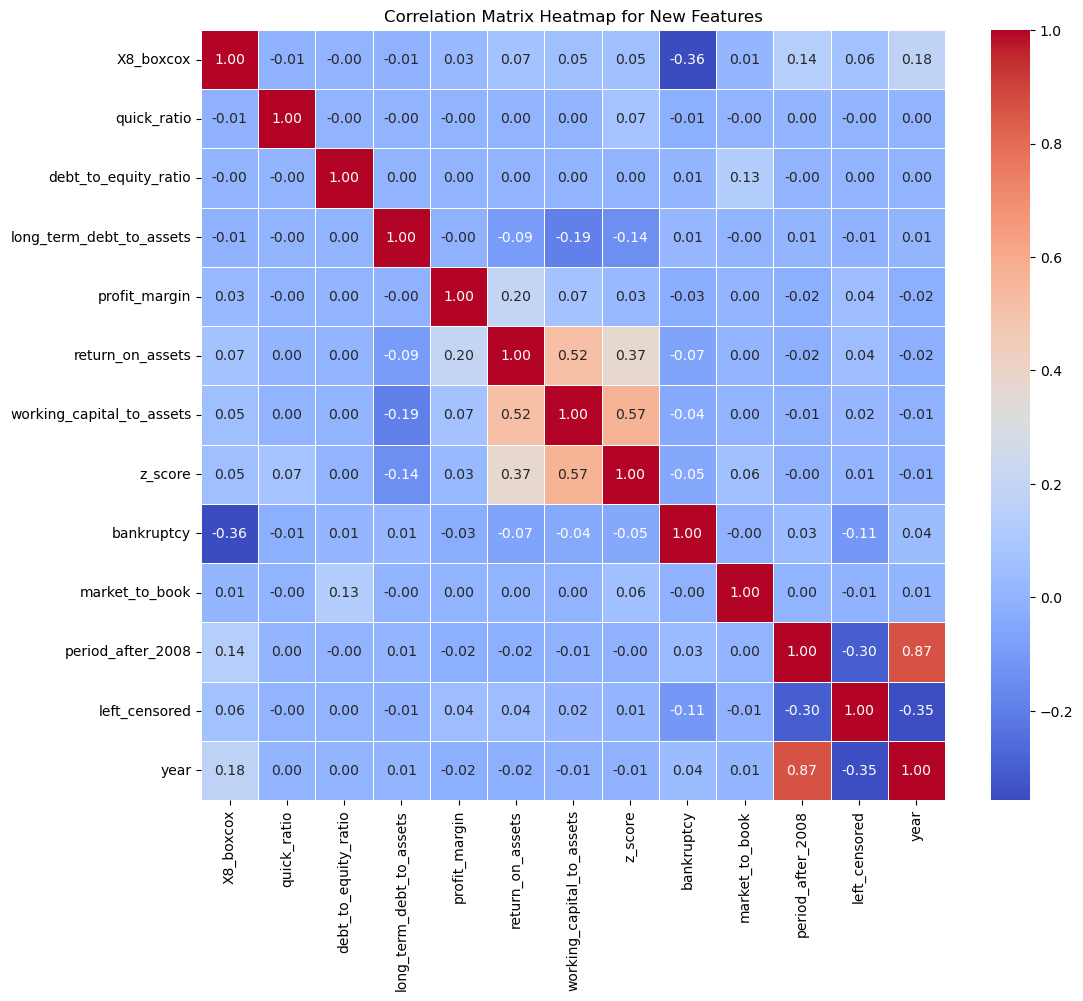

In [218]:
import seaborn as sns

# Convert the specified columns to numeric
for column in selected_features:
    df[column] = pd.to_numeric(df[column], errors='coerce')

# Calculate the correlation matrix for the newly created variables
corr_matrix_new_vars = df[selected_features].corr().round(3)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_new_vars, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap for New Features')
plt.show()

In [220]:
import numpy as np
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a DataFrame to calculate VIF
X = df[selected_features]  # Replace 'new_features' with the list of your features
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Replace inf values with a descriptive label and round VIF values
vif_data["VIF"] = vif_data["VIF"].replace(np.inf, np.nan)  # Replace inf with NaN for clarity
vif_data["VIF"] = vif_data["VIF"].round(3)  # Round to 3 decimal places

# Sort by VIF values for better readability
vif_data = vif_data.sort_values(by="VIF", ascending=False)

# Print the cleaned VIF values
print(vif_data)


                     Variable    VIF
12                       year  4.146
10          period_after_2008  4.039
6   working_capital_to_assets  1.790
7                     z_score  1.526
5            return_on_assets  1.442
0                   X8_boxcox  1.205
8                  bankruptcy  1.164
4               profit_margin  1.048
11              left_censored  1.046
3    long_term_debt_to_assets  1.040
9              market_to_book  1.022
2        debt_to_equity_ratio  1.017
1                 quick_ratio  1.008


Transformed
long_term_debt_to_assets_reciprocal, 
working_capital_to_assets_sqrt
z_score_log
debt_to_equity_ratio_shifted_boxcox
return_on_assets_shifted_boxcox
market_to_book_shifted_boxcox

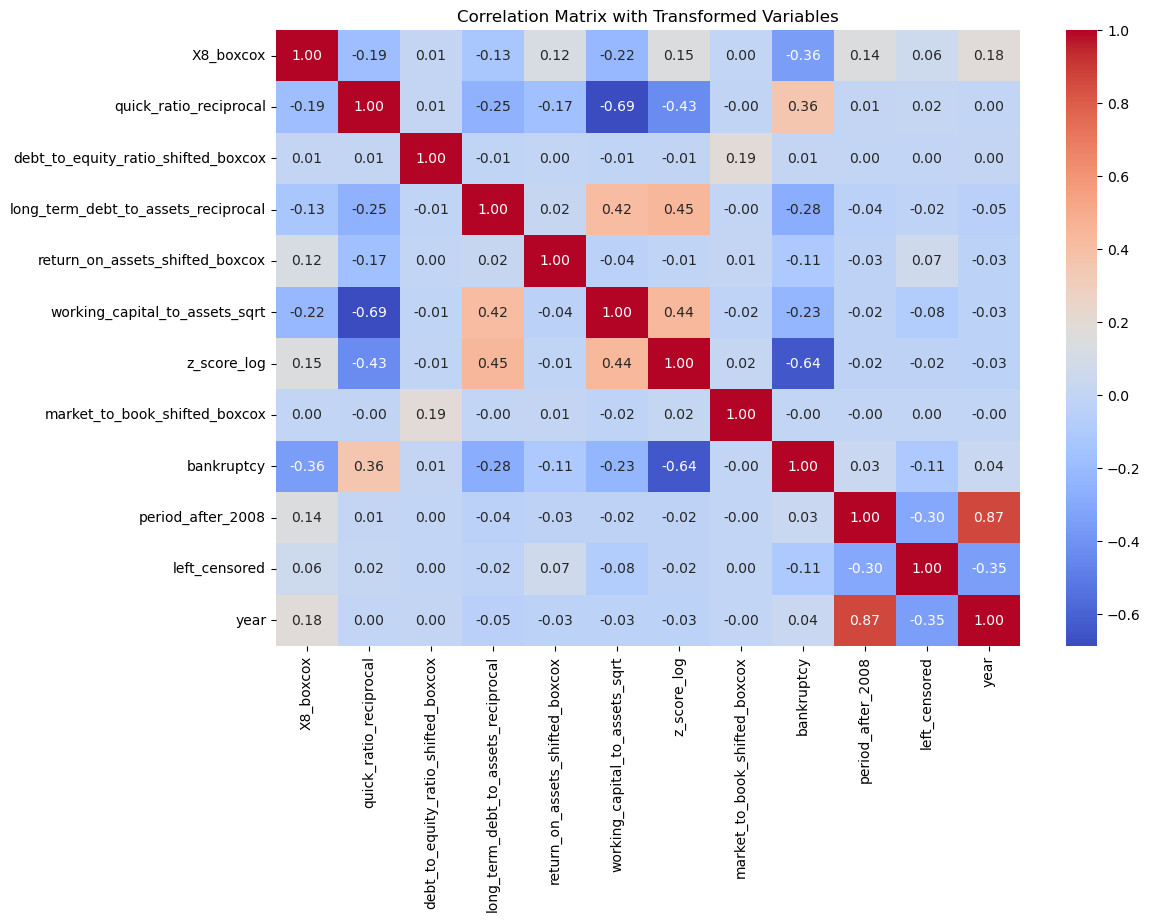

In [221]:
import seaborn as sns
import matplotlib.pyplot as plt

# Update the selected features with transformed variables
selected_features_transformed = [
    'X8_boxcox',  # Keep original if not transformed
    'quick_ratio_reciprocal',
    'debt_to_equity_ratio_shifted_boxcox',
    'long_term_debt_to_assets_reciprocal',
    'return_on_assets_shifted_boxcox',
    'working_capital_to_assets_sqrt',
    'z_score_log',
    'market_to_book_shifted_boxcox',
    'bankruptcy',  # Keep original if not transformed
    'period_after_2008',  # Keep original if not transformed
    'left_censored',  # Keep original if not transformed
    'year'  # Keep original if not transformed
]

# Create the correlation matrix
correlation_matrix = df[selected_features_transformed].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix with Transformed Variables")
plt.show()

In [ ]:
# Features to select from:
#'X8_boxcox', 'quick_ratio', 'debt_to_equity_ratio', 
#    'long_term_debt_to_assets', 'profit_margin',  'return_on_assets', 
#    'working_capital_to_assets', 'z_score', 'bankruptcy', 
#    'market_to_book', 'period_after_2008', 'left_censored'

In [ ]:
# List of transformed selected features
# 'X8_boxcox', 'quick_ratio_reciprocal',
# 'debt_to_equity_ratio_shifted_boxcox',
# 'long_term_debt_to_assets_reciprocal',
# 'return_on_assets_shifted_boxcox',
# 'working_capital_to_assets_sqrt',
# 'z_score_log',
# 'market_to_book_shifted_boxcox',
# 'bankruptcy',  
# 'period_after_2008',  
#  'left_censored', 
# 'year'

In [ ]:
# Select features for inclusion in the model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Define the selected features and target variable
selected_features = [
    'X8_boxcox',  
    'return_on_assets', 
    'quick_ratio',
    'debt_to_equity_ratio', 
    'working_capital_to_assets',  
    'market_to_book', 
    'bankruptcy',
    'year'
]
X = df[selected_features]
y = df['target_last']  # the binary target variable

# Check for missing values in the selected features and target
print("Missing values in features:\n", X.isna().sum())
print("Missing values in target:", y.isna().sum())


Missing values in features:
 X8_boxcox                    0
return_on_assets             0
quick_ratio                  0
debt_to_equity_ratio         0
working_capital_to_assets    0
market_to_book               0
bankruptcy                   0
year                         0
dtype: int64
Missing values in target: 0


In [197]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Define the features (X) and target (y)
X = df[selected_features]  # Example features
y = df['target_last']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the logistic regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = log_reg.predict(X_test)

# Evaluate the model
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     15608
           1       0.00      0.00      0.00       129

    accuracy                           0.99     15737
   macro avg       0.50      0.50      0.50     15737
weighted avg       0.98      0.99      0.99     15737

Accuracy: 0.9917392133189299


In [198]:
# Check feature coefficients
coefficients = pd.DataFrame({'Feature': selected_features, 'Coefficient': log_reg.coef_[0]})
print("\nFeature Coefficients:")
print(coefficients)


Feature Coefficients:
                     Feature  Coefficient
0                  X8_boxcox    -0.518787
1           return_on_assets     0.100786
2                quick_ratio    -0.079838
3       debt_to_equity_ratio     0.147871
4  working_capital_to_assets     0.150465
5             market_to_book    -0.147596
6                 bankruptcy     0.791037
7                       year    -0.002718


In [199]:
import statsmodels.api as sm

# Add a constant to the features for the intercept
X_with_const = sm.add_constant(X)

# Fit the logistic regression model
logit_model = sm.Logit(y, X_with_const)
result = logit_model.fit()

# Print the summary
print(result.summary())

c:\Users\deanh\miniconda3\envs\dsi_participant\lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.040178
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:            target_last   No. Observations:                78682
Model:                          Logit   Df Residuals:                    78673
Method:                           MLE   Df Model:                            8
Date:                Wed, 19 Mar 2025   Pseudo R-squ.:                  0.1138
Time:                        14:33:25   Log-Likelihood:                -3161.3
converged:                       True   LL-Null:                       -3567.2
Covariance Type:            nonrobust   LLR p-value:                5.849e-170
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      -130.4410     14.503     -8.994      0.000    -158

c:\Users\deanh\miniconda3\envs\dsi_participant\lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


 COX PH

In [201]:
# Use target_last as the event column
df['event'] = df['target_last']

# Create the 'duration' column (time from the first year to the last year for each company)
df['duration'] = df.groupby('company_name')['year'].transform(lambda x: x.max() - x.min() + 1)


In [202]:
from sklearn.preprocessing import StandardScaler

# Standardize the features
features_to_standardize = [
    'X8_boxcox', 'return_on_assets', 'quick_ratio', 
    'debt_to_equity_ratio', 'working_capital_to_assets', 
    'market_to_book', 'bankruptcy','year'
]
scaler = StandardScaler()
df[features_to_standardize] = scaler.fit_transform(df[features_to_standardize])

In [203]:
from lifelines import CoxPHFitter

# Define the dataset for the Cox PH model
cox_data = df[['X8_boxcox',  
               'return_on_assets', 
               'quick_ratio',
               'debt_to_equity_ratio', 
               'working_capital_to_assets',  
               'market_to_book',  
               'year',
               'duration',  # Include the duration column
               'event']]    # Include the event column

# Initialize and fit the Cox PH model
cox_model = CoxPHFitter()
cox_model.fit(cox_data, duration_col='duration', event_col='event')

# Extract the summary as a DataFrame and round to 3 decimal places
summary_df = cox_model.summary.round(3)

# Display the summary DataFrame
print(summary_df)


c:\Users\deanh\miniconda3\envs\dsi_participant\lib\site-packages\lifelines\fitters\coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(


                            coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                               
X8_boxcox                 -1.872      0.154     0.061          -1.991   
return_on_assets           0.094      1.099     0.028           0.039   
quick_ratio               -2.041      0.130     1.161          -4.317   
debt_to_equity_ratio       0.035      1.036     0.009           0.017   
working_capital_to_assets -0.049      0.952     0.004          -0.058   
market_to_book            -0.093      0.911     0.426          -0.928   
year                       0.534      1.707     0.044           0.447   

                           coef upper 95%  exp(coef) lower 95%  \
covariate                                                        
X8_boxcox                          -1.752                0.137   
return_on_assets                    0.149                1.040   
quick_ratio                         0.235                0.013   
debt_to_equi

**# we will want to explore lags here as well, but need to be careful of generating NaNs.** 

Interpreting the effects: 
Hazard Ratios (HR):
- Derived from the exponentiation of the coefficients (exp(coef)).

- Indicate the multiplicative effect of a one-unit increase in the predictor on the hazard.

HR > 1: Increases the hazard (higher risk).
HR < 1: Decreases the hazard (lower risk).
HR = 1: No effect on the hazard.

- then check p-value for significance

A lot to fix here but just a quick shot.

# Here are some ideas for next steps:

**This part is mostly done though still verifying some issues as outlined at the top, and cleaning up this code and testing different versions of the model **
- Explore the Data: structure and summary statistics partly done. The variable descriptions can found on kaggle.
- Check for Missing Data: Identify and handle missing values with imputation or removal. Will need to be careful with lags etc.
- Understand Target Variable: check bankruptcy label to identify class imbalance. (discussed at the top)

# Feature Engineering
This is done - all described above
- Financial Ratios: Create ratios like Debt-to-Equity, Current Ratio, or Asset Turnover to capture relationships between variables.
**I haven't done this but will**
- Log Transformation: Apply logarithmic transformation to variables with high skewness (e.g., Total Assets, Net Income).**I haven't done this but will**
- Normalize/Standardize: Scale all numerical features for models sensitive to magnitude differences.**I have done some of this.**

# Choose and Apply ML Models
Here are some ML methods for predicting bankruptcy:

Traditional Algorithms:
- Logistic Regression (baseline model). **I've run one model.**
- Random Forests (for feature importance and accuracy).
- Gradient Boosting (e.g., XGBoost, LightGBM, CatBoost for high performance).

Survival Analysis:
- Use the Cox Proportional Hazards model predicts the time-to-bankruptcy. **I've tested some features but just have one model here.**
- Random Survival Forests for time-to-event predictions with complex interactions.

Deep Learning:
Neural networks to model complex non-linear relationships??

# Address Class Imbalance
If bankrupt companies are underrepresented:
- Use techniques like oversampling (SMOTE) or undersampling.
- Adjust class weights in models to prevent bias towards the majority class.

# Evaluate the Models
- Accuracy & F1-Score: For balanced datasets.
- Precision-Recall: Focus on identifying bankrupt companies when the dataset is imbalanced.
- ROC-AUC: For overall model discrimination.

# Visualize Results
- Visualize survival curves for bankruptcy risks using Kaplan-Meier or Cox PH models.
- Plot feature importance from models like Random Forest or Gradient Boosting to identify key bankruptcy predictors.
- Use correlation heatmaps to show relationships between financial variables.

Some possible interactions (future research): 
1. Size × Leverage
Interaction between company size (e.g., total assets) and leverage ratios (e.g., debt-to-equity ratio) could reveal how the impact of leverage on bankruptcy risk varies with company size. For instance, smaller firms might be more vulnerable to high leverage compared to larger firms.

2. Profitability × Liquidity
The relationship between profitability (e.g., net income) and liquidity (e.g., current ratio) might interact to influence bankruptcy risk. A profitable company with poor liquidity could still face short-term financial distress.

3. Growth × Leverage
Interaction between growth metrics (e.g., revenue growth) and leverage could highlight how rapidly growing companies manage debt differently and how this affects bankruptcy risk.